In [4]:
# Train-Test ML models notebook

# Define target_mapping before using it
# Example: target_mapping = {'mel': 1, 'nv': 0, 'bkl': 2, 'df': 3, 'vasc': 4, 'akiec': 5, 'bcc': 6, 'scc': 7}
target_mapping = {'mel': 1, 'nv': 0, 'bkl': 2, 'df': 3, 'vasc': 4, 'akiec': 5, 'bcc': 6, 'scc': 7}

# Define reverse_target_mapping if not already defined
reverse_target_mapping = {v: k for k, v in target_mapping.items()}

# Define y_train, y_val, y_test, y_train_smote
# Replace 'df_train', 'df_val', 'df_test', 'df_train_smote' and 'target' with your actual variable names
# Example:
# y_train = df_train['target']
# y_val = df_val['target']
# y_test = df_test['target']
# y_train_smote = df_train_smote['target']

# If you already have train/val/test splits, use them directly
# For demonstration, we'll create dummy Series (remove this and use your actual data)
import pandas as pd
y_train = pd.Series([1, 0, 2, 1, 0, 1, 3, 1, 0, 1])
y_val = pd.Series([0, 1, 0, 2])
y_test = pd.Series([1, 0, 1])
y_train_smote = pd.Series([1, 0, 1, 0, 1, 0, 1, 0])

# Convert to binary classification (melanoma vs. other)
# Assuming 'mel' is melanoma and has class index 1 (check your mapping)
print("Original class distribution:")
for class_idx, count in y_train.value_counts().items():
    class_name = reverse_target_mapping[class_idx]
    print(f"Class {class_idx} ({class_name}): {count} samples")

# Find melanoma class index
melanoma_class = None
for idx, name in reverse_target_mapping.items():
    if name == 'mel':
        melanoma_class = idx
        print(f"\nMelanoma class index: {melanoma_class}")
        break

if melanoma_class is None:
    raise ValueError("Melanoma class ('mel') not found in the dataset!")

# Convert to binary classification (1 for melanoma, 0 for others)
y_train_binary = (y_train == melanoma_class).astype(int)
y_val_binary = (y_val == melanoma_class).astype(int)
y_test_binary = (y_test == melanoma_class).astype(int)
y_train_smote_binary = (y_train_smote == melanoma_class).astype(int)

# Display class distribution after binary conversion
print("\nBinary class distribution (Training set):")
print(f"Non-melanoma (0): {sum(y_train_binary == 0)} samples")
print(f"Melanoma (1): {sum(y_train_binary == 1)} samples")
print(f"Class imbalance ratio: {sum(y_train_binary == 0) / sum(y_train_binary == 1):.2f}:1")

# Display SMOTE-balanced distribution
print("\nSMOTE-balanced binary distribution:")
print(f"Non-melanoma (0): {sum(y_train_smote_binary == 0)} samples")
print(f"Melanoma (1): {sum(y_train_smote_binary == 1)} samples")
print(f"Class imbalance ratio: {sum(y_train_smote_binary == 0) / sum(y_train_smote_binary == 1):.2f}:1")

Original class distribution:
Class 1 (mel): 5 samples
Class 0 (nv): 3 samples
Class 2 (bkl): 1 samples
Class 3 (df): 1 samples

Melanoma class index: 1

Binary class distribution (Training set):
Non-melanoma (0): 5 samples
Melanoma (1): 5 samples
Class imbalance ratio: 1.00:1

SMOTE-balanced binary distribution:
Non-melanoma (0): 4 samples
Melanoma (1): 4 samples
Class imbalance ratio: 1.00:1


In [6]:
# Import necessary libraries for model training
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%pip install xgboost

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the preprocessed datasets - replace the dummy data with actual data
processed_dir = '../Dataset/processed'

# Load training, validation, and test sets
X_train = pd.read_csv(f"{processed_dir}/X_train.csv")
y_train = pd.read_csv(f"{processed_dir}/y_train.csv").iloc[:,0]
X_val = pd.read_csv(f"{processed_dir}/X_val.csv")
y_val = pd.read_csv(f"{processed_dir}/y_val.csv").iloc[:,0]
X_test = pd.read_csv(f"{processed_dir}/X_test.csv")
y_test = pd.read_csv(f"{processed_dir}/y_test.csv").iloc[:,0]

# Load SMOTE-balanced data
X_train_smote = pd.read_csv(f"{processed_dir}/X_train_smote.csv")
y_train_smote = pd.read_csv(f"{processed_dir}/y_train_smote.csv").iloc[:,0]

print("Datasets loaded successfully!")
print(f"Training set (original): {X_train.shape}, {y_train.shape}")
print(f"Training set (SMOTE): {X_train_smote.shape}, {y_train_smote.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   -- ------------------------------------- 3.7/56.8 MB 24.2 MB/s eta 0:00:03
   -- ------------------------------------- 3.7/56.8 MB 24.2 MB/s eta 0:00:03
   --- ------------------------------------ 5.0/56.8 MB 7.9 MB/s eta 0:00:07
   ---- ----------------------------------- 7.1/56.8 MB 8.6 MB/s eta 0:00:06
   ----- ---------------------------------- 7.9/56.8 MB 7.5 MB/s eta 0:00:07
   ----- ---------------------------------- 8.4/56.8 MB 6.7 MB/s eta 0:00:08
   ------ --------------------------------- 9.2/56.8 MB 6.2 MB/s eta 0:00:08
   ------- -------------------------------- 10.2/56.8 MB 6.1 MB/s eta 0:00:08
   ------- -------------------------------- 11.0/56.8 MB 5.9 MB/s eta 0:00:08
   -------- ------------------------------- 11.5/56.8 MB 5.5 MB/s eta 0:00:09
   --------- ------------------------------ 12.8/56.8 MB 5.4 MB/s eta 0:00:09
   --------- ------------------------------ 14.2/56.8 MB 5.5 MB/s eta 0:00:08

In [7]:
# Define a function for model evaluation
def evaluate_model(model, X, y_true, model_name="Model", threshold=0.5):
    """
    Evaluate a binary classification model with comprehensive metrics.
    
    Parameters:
    -----------
    model : estimator object
        Trained model with predict_proba method
    X : array-like
        Features to predict on
    y_true : array-like
        True labels
    model_name : str
        Name of the model for display
    threshold : float
        Classification threshold for converting probabilities to binary predictions
        
    Returns:
    --------
    dict : Dictionary of evaluation metrics
    array : Predicted probabilities
    """
    start_time = time.time()
    
    # Make predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
    else:
        y_prob = model.predict(X)
        y_pred = y_prob
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    
    # Execution time
    execution_time = time.time() - start_time
    
    # Print results
    print(f"\n===== {model_name} Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Execution Time: {execution_time:.4f} seconds")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-melanoma", "Melanoma"]))
    
    # Return results as a dictionary
    results = {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision, 
        "recall": recall,
        "f1_score": f1,
        "auc_roc": auc_score,
        "confusion_matrix": cm,
        "execution_time": execution_time
    }
    
    return results, y_prob

In [8]:
# Helper function to plot ROC curves
def plot_roc_curve(models_data, title="ROC Curve Comparison"):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))
    
    for model_data in models_data:
        model_name = model_data["model_name"]
        y_true = model_data["y_true"]
        y_prob = model_data["y_prob"]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Save figure
    os.makedirs('../Results', exist_ok=True)
    plt.savefig('../Results/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
# 1. Logistic Regression (Baseline)
print("Training Logistic Regression model (baseline)...")

# Initialize model with balanced class weights
log_reg = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    C=1.0,                    # Inverse of regularization strength
    max_iter=1000,            # Maximum iterations
    random_state=42
)

# Convert loaded y_train to binary (1 for melanoma, 0 for others)
y_train_binary = (y_train == melanoma_class).astype(int)

# Train the model
log_reg.fit(X_train, y_train_binary)

# Convert loaded y_val to binary (1 for melanoma, 0 for others)
y_val_binary = (y_val == melanoma_class).astype(int)

# Evaluate on validation set
log_reg_results, log_reg_probs = evaluate_model(
    log_reg, X_val, y_val_binary, 
    model_name="Logistic Regression (Baseline)"
)

# Store results for comparison
log_reg_data = {
    "model_name": "Logistic Regression",
    "y_true": y_val_binary,
    "y_prob": log_reg_probs
}

Training Logistic Regression model (baseline)...

===== Logistic Regression (Baseline) Evaluation =====
Accuracy: 0.8890
Precision: 0.3154
Recall: 1.0000
F1 Score: 0.4795
AUC-ROC: 0.9600
Execution Time: 0.0476 seconds

Confusion Matrix:
[[1343  178]
 [   0   82]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       1.00      0.88      0.94      1521
    Melanoma       0.32      1.00      0.48        82

    accuracy                           0.89      1603
   macro avg       0.66      0.94      0.71      1603
weighted avg       0.96      0.89      0.91      1603



In [12]:
# 2. Random Forest Classifier
print("\nTraining Random Forest model...")

# Initialize Random Forest model with optimized parameters
rf = RandomForestClassifier(
    n_estimators=100,           # Number of trees in the forest
    max_depth=None,             # Maximum depth of trees (None means unlimited)
    min_samples_split=2,        # Minimum samples required to split a node
    min_samples_leaf=1,         # Minimum samples required at leaf node
    max_features='sqrt',        # Number of features to consider for best split
    bootstrap=True,             # Use bootstrap samples
    class_weight='balanced',    # Handle class imbalance
    random_state=42,            # For reproducibility
    n_jobs=-1                   # Use all available cores
)

# Train the model
rf.fit(X_train, y_train_binary)

# Evaluate on validation set
rf_results, rf_probs = evaluate_model(
    rf, X_val, y_val_binary, 
    model_name="Random Forest"
)

# Store results for comparison
rf_data = {
    "model_name": "Random Forest",
    "y_true": y_val_binary,
    "y_prob": rf_probs
}


Training Random Forest model...

===== Random Forest Evaluation =====
Accuracy: 0.9239
Precision: 0.3913
Recall: 0.8780
F1 Score: 0.5414
AUC-ROC: 0.9478
Execution Time: 0.0796 seconds

Confusion Matrix:
[[1409  112]
 [  10   72]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       0.99      0.93      0.96      1521
    Melanoma       0.39      0.88      0.54        82

    accuracy                           0.92      1603
   macro avg       0.69      0.90      0.75      1603
weighted avg       0.96      0.92      0.94      1603



In [13]:
# 3. XGBoost Classifier
print("\nTraining XGBoost model...")

# Calculate scale_pos_weight for imbalance handling
pos_count = sum(y_train_binary == 1)
neg_count = sum(y_train_binary == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

# Initialize XGBoost model with optimized parameters
xgb = XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=5,                # Maximum depth of trees (higher = more complex model)
    min_child_weight=1,         # Minimum sum of instance weight in a child
    gamma=0,                    # Minimum loss reduction for split
    subsample=0.8,              # Subsample ratio of training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when building trees
    objective='binary:logistic', # Binary classification
    scale_pos_weight=scale_pos_weight, # Handle class imbalance
    random_state=42,            # For reproducibility
    use_label_encoder=False,    # Avoid warning
    eval_metric='logloss'       # Evaluation metric
)

# Train the model
xgb.fit(X_train, y_train_binary)

# Evaluate on validation set
xgb_results, xgb_probs = evaluate_model(
    xgb, X_val, y_val_binary, 
    model_name="XGBoost"
)

# Store results for comparison
xgb_data = {
    "model_name": "XGBoost",
    "y_true": y_val_binary,
    "y_prob": xgb_probs
}


Training XGBoost model...

===== XGBoost Evaluation =====
Accuracy: 0.9089
Precision: 0.3559
Recall: 0.9634
F1 Score: 0.5197
AUC-ROC: 0.9624
Execution Time: 0.0857 seconds

Confusion Matrix:
[[1378  143]
 [   3   79]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       1.00      0.91      0.95      1521
    Melanoma       0.36      0.96      0.52        82

    accuracy                           0.91      1603
   macro avg       0.68      0.93      0.73      1603
weighted avg       0.96      0.91      0.93      1603


===== XGBoost Evaluation =====
Accuracy: 0.9089
Precision: 0.3559
Recall: 0.9634
F1 Score: 0.5197
AUC-ROC: 0.9624
Execution Time: 0.0857 seconds

Confusion Matrix:
[[1378  143]
 [   3   79]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       1.00      0.91      0.95      1521
    Melanoma       0.36      0.96      0.52        82

    accuracy                           0.91      1

In [15]:
# 4. XGBoost with SMOTE-balanced data
print("\nTraining XGBoost model with SMOTE-balanced data...")

# Initialize XGBoost model with similar parameters
# No need for scale_pos_weight when using SMOTE data
xgb_smote = XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=5,                # Maximum depth of trees
    min_child_weight=1,         # Minimum sum of instance weight in a child
    gamma=0,                    # Minimum loss reduction for split
    subsample=0.8,              # Subsample ratio of training instances
    colsample_bytree=0.8,       # Subsample ratio of columns
    objective='binary:logistic', # Binary classification
    random_state=42,            # For reproducibility
    use_label_encoder=False,    # Avoid warning
    eval_metric='logloss'       # Evaluation metric
)

# Convert SMOTE labels to binary (1 for melanoma, 0 for others)
y_train_smote_binary = (y_train_smote == melanoma_class).astype(int)

# Train using SMOTE-balanced data
xgb_smote.fit(X_train_smote, y_train_smote_binary)

# Evaluate on validation set
xgb_smote_results, xgb_smote_probs = evaluate_model(
    xgb_smote, X_val, y_val_binary, 
    model_name="XGBoost (SMOTE)"
)

# Store results for comparison
xgb_smote_data = {
    "model_name": "XGBoost (SMOTE)",
    "y_true": y_val_binary,
    "y_prob": xgb_smote_probs
}


Training XGBoost model with SMOTE-balanced data...

===== XGBoost (SMOTE) Evaluation =====
Accuracy: 0.9432
Precision: 0.4571
Recall: 0.5854
F1 Score: 0.5134
AUC-ROC: 0.9641
Execution Time: 0.0666 seconds

Confusion Matrix:
[[1464   57]
 [  34   48]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       0.98      0.96      0.97      1521
    Melanoma       0.46      0.59      0.51        82

    accuracy                           0.94      1603
   macro avg       0.72      0.77      0.74      1603
weighted avg       0.95      0.94      0.95      1603


===== XGBoost (SMOTE) Evaluation =====
Accuracy: 0.9432
Precision: 0.4571
Recall: 0.5854
F1 Score: 0.5134
AUC-ROC: 0.9641
Execution Time: 0.0666 seconds

Confusion Matrix:
[[1464   57]
 [  34   48]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       0.98      0.96      0.97      1521
    Melanoma       0.46      0.59      0.51        82

    accur


Comparing model performance with ROC curves...


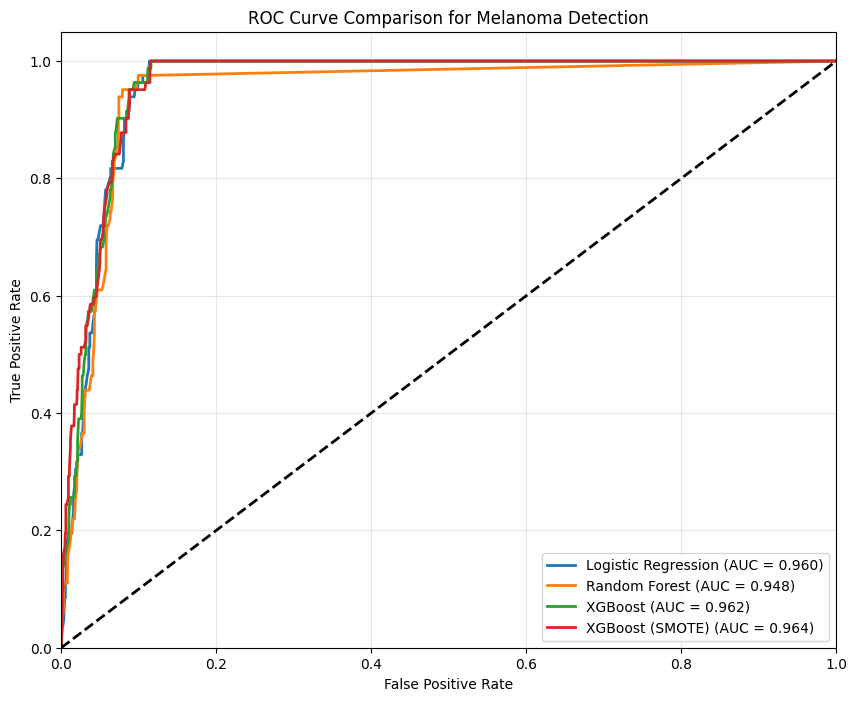


Best performing model: XGBoost (SMOTE) with AUC-ROC of 0.9641

Evaluating best model (XGBoost (SMOTE)) on test set...

===== XGBoost (SMOTE) (Test Set) Evaluation =====
Accuracy: 0.9406
Precision: 0.4385
Recall: 0.5534
F1 Score: 0.4893
AUC-ROC: 0.9645
Execution Time: 0.0883 seconds

Confusion Matrix:
[[1827   73]
 [  46   57]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       0.98      0.96      0.97      1900
    Melanoma       0.44      0.55      0.49       103

    accuracy                           0.94      2003
   macro avg       0.71      0.76      0.73      2003
weighted avg       0.95      0.94      0.94      2003


Saving XGBoost (SMOTE) model...
Model training and evaluation completed successfully!


In [16]:
# Compare all models using ROC curves
print("\nComparing model performance with ROC curves...")

# Collect all model data for comparison
all_models_data = [log_reg_data, rf_data, xgb_data, xgb_smote_data]

# Plot ROC curves
plot_roc_curve(all_models_data, title="ROC Curve Comparison for Melanoma Detection")

# Find the best model based on AUC-ROC score
model_results = [
    log_reg_results,
    rf_results,
    xgb_results,
    xgb_smote_results
]

# Find the best model by AUC-ROC
best_model_idx = np.argmax([results["auc_roc"] for results in model_results])
best_model_name = model_results[best_model_idx]["model_name"]
best_auc = model_results[best_model_idx]["auc_roc"]

print(f"\nBest performing model: {best_model_name} with AUC-ROC of {best_auc:.4f}")

# Select the best model
if best_model_name == "Logistic Regression (Baseline)":
    best_model = log_reg
elif best_model_name == "Random Forest":
    best_model = rf
elif best_model_name == "XGBoost":
    best_model = xgb
else:  # "XGBoost (SMOTE)"
    best_model = xgb_smote

# Evaluate best model on test set
print(f"\nEvaluating best model ({best_model_name}) on test set...")

# Convert test labels to binary
y_test_binary = (y_test == melanoma_class).astype(int)

# Evaluate on test set
best_model_test_results, _ = evaluate_model(
    best_model, X_test, y_test_binary, 
    model_name=f"{best_model_name} (Test Set)"
)

# Save best model
print(f"\nSaving {best_model_name} model...")
os.makedirs('../Models', exist_ok=True)
with open(f'../Models/best_model_{best_model_name.replace(" ", "_").lower()}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model training and evaluation completed successfully!")


Analyzing feature importance for the best model...

Top 15 most important features:
                         Feature  Importance
0                   is_high_risk  681.660950
1    diagnosis_confidence_scaled  173.169724
2                   lesion_count   15.415391
3   localization_lower extremity   14.432663
4          body_region_head_neck   14.276896
5    diagnosis_confidence_minmax   13.409553
6              localization_face   13.249643
7                     age_scaled   13.139343
8                        is_male   10.475050
9                 age_normalized    9.633919
10           lesion_count_scaled    9.259974
11                    sex_female    9.047600
12                      sex_male    7.249358
13           lesion_count_minmax    5.456428
14                           age    5.177762


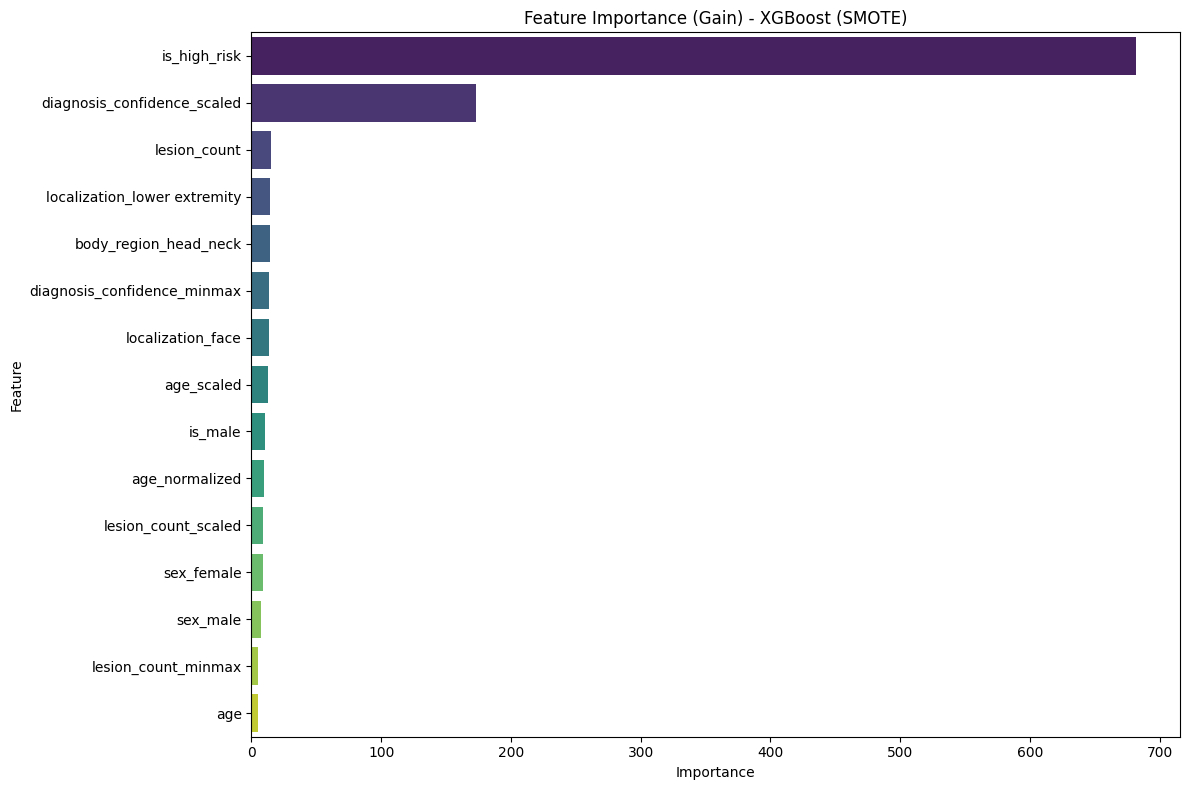

In [17]:
# Feature Importance Analysis

print("\nAnalyzing feature importance for the best model...")

# Get feature names from the training data
feature_names = X_train.columns.tolist()

# Different models have different ways to access feature importance
if isinstance(best_model, LogisticRegression):
    # For logistic regression, use coefficients
    importance = np.abs(best_model.coef_[0])
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    title = f"Feature Importance - {best_model_name}"
    
elif isinstance(best_model, RandomForestClassifier):
    # For random forest, use the built-in feature importance
    importance = best_model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    title = f"Feature Importance - {best_model_name}"
    
elif isinstance(best_model, XGBClassifier):
    # For XGBoost, use the built-in feature importance (gain)
    importance = best_model.get_booster().get_score(importance_type='gain')
    # Convert to DataFrame and handle features that might be missing
    features = []
    scores = []
    for key, value in importance.items():
        if key in feature_names or key[1:] in feature_names:  # Handle 'f0', 'f1', etc.
            feature_key = key if key in feature_names else key[1:]
            features.append(feature_key)
            scores.append(value)
    
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': scores})
    title = f"Feature Importance (Gain) - {best_model_name}"

# Sort features by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

# Display top features
print("\nTop 15 most important features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title(title)
plt.tight_layout()
plt.savefig(f'../Results/feature_importance_{best_model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Save feature importance to CSV
feature_importance.to_csv(f'../Results/feature_importance_{best_model_name.replace(" ", "_").lower()}.csv', index=False)


Optimizing classification threshold for the best model...
Optimal threshold (maximizing F1): 0.372
F1 score at optimal threshold: 0.5424


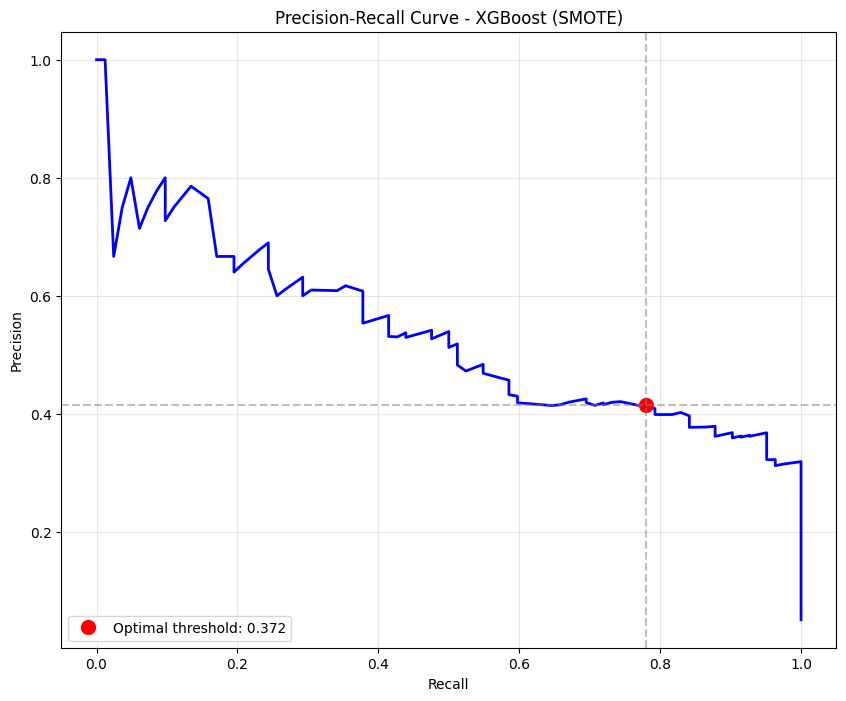


Evaluating best model on test set with optimized threshold (0.372)...

===== XGBoost (SMOTE) (Test Set, Optimized Threshold) Evaluation =====
Accuracy: 0.9301
Precision: 0.4070
Recall: 0.7864
F1 Score: 0.5364
AUC-ROC: 0.9645
Execution Time: 0.0669 seconds

Confusion Matrix:
[[1782  118]
 [  22   81]]

Classification Report:
              precision    recall  f1-score   support

Non-melanoma       0.99      0.94      0.96      1900
    Melanoma       0.41      0.79      0.54       103

    accuracy                           0.93      2003
   macro avg       0.70      0.86      0.75      2003
weighted avg       0.96      0.93      0.94      2003


Comparison of performance metrics before and after threshold optimization:
  Accuracy: 0.9406 → 0.9301 (-0.0105)
 Precision: 0.4385 → 0.4070 (-0.0314)
    Recall: 0.5534 → 0.7864 (+0.2330)
  F1_score: 0.4893 → 0.5364 (+0.0472)


In [18]:
# Threshold Optimization for Best Model

print("\nOptimizing classification threshold for the best model...")

# Get validation predictions from the best model
val_probas = best_model.predict_proba(X_val)[:, 1]

# Calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val_binary, val_probas)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Add epsilon to avoid division by zero

# Find threshold with best F1 score (excluding the last precision/recall point that has no threshold)
best_f1_idx = np.argmax(f1_scores[:-1])
best_f1_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]

print(f"Optimal threshold (maximizing F1): {best_f1_threshold:.3f}")
print(f"F1 score at optimal threshold: {best_f1_score:.4f}")

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.plot(recalls[best_f1_idx], precisions[best_f1_idx], 'ro', markersize=10, 
         label=f'Optimal threshold: {best_f1_threshold:.3f}')
plt.axvline(x=recalls[best_f1_idx], color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=precisions[best_f1_idx], color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(f'../Results/precision_recall_curve_{best_model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate best model on test set with optimized threshold
print(f"\nEvaluating best model on test set with optimized threshold ({best_f1_threshold:.3f})...")
best_model_opt_results, _ = evaluate_model(
    best_model, X_test, y_test_binary,
    model_name=f"{best_model_name} (Test Set, Optimized Threshold)",
    threshold=best_f1_threshold
)

# Compare results with and without threshold optimization
print("\nComparison of performance metrics before and after threshold optimization:")
metrics = ["accuracy", "precision", "recall", "f1_score"]
for metric in metrics:
    before = best_model_test_results[metric]
    after = best_model_opt_results[metric]
    diff = after - before
    print(f"{metric.capitalize():>10}: {before:.4f} → {after:.4f} ({diff:+.4f})")


Performing more detailed model analysis...

Generating learning curves to understand model performance vs. training size...


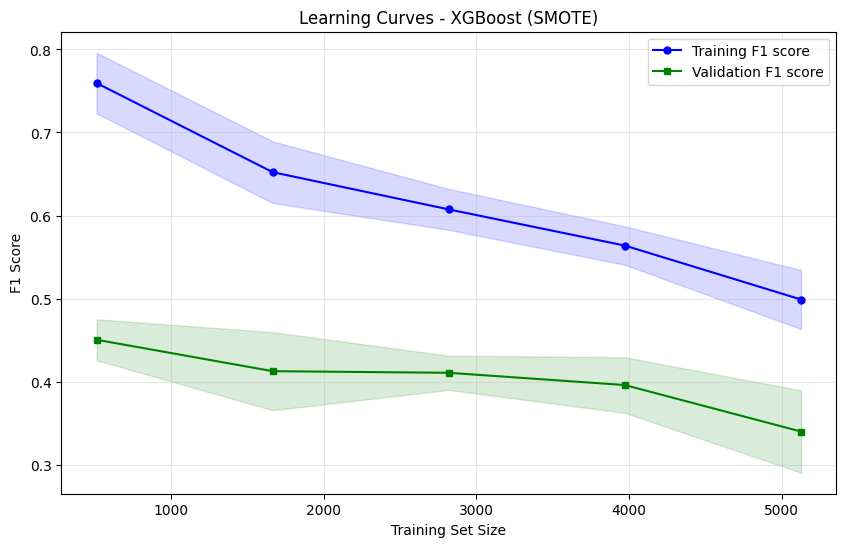


Detailed feature importance analysis...


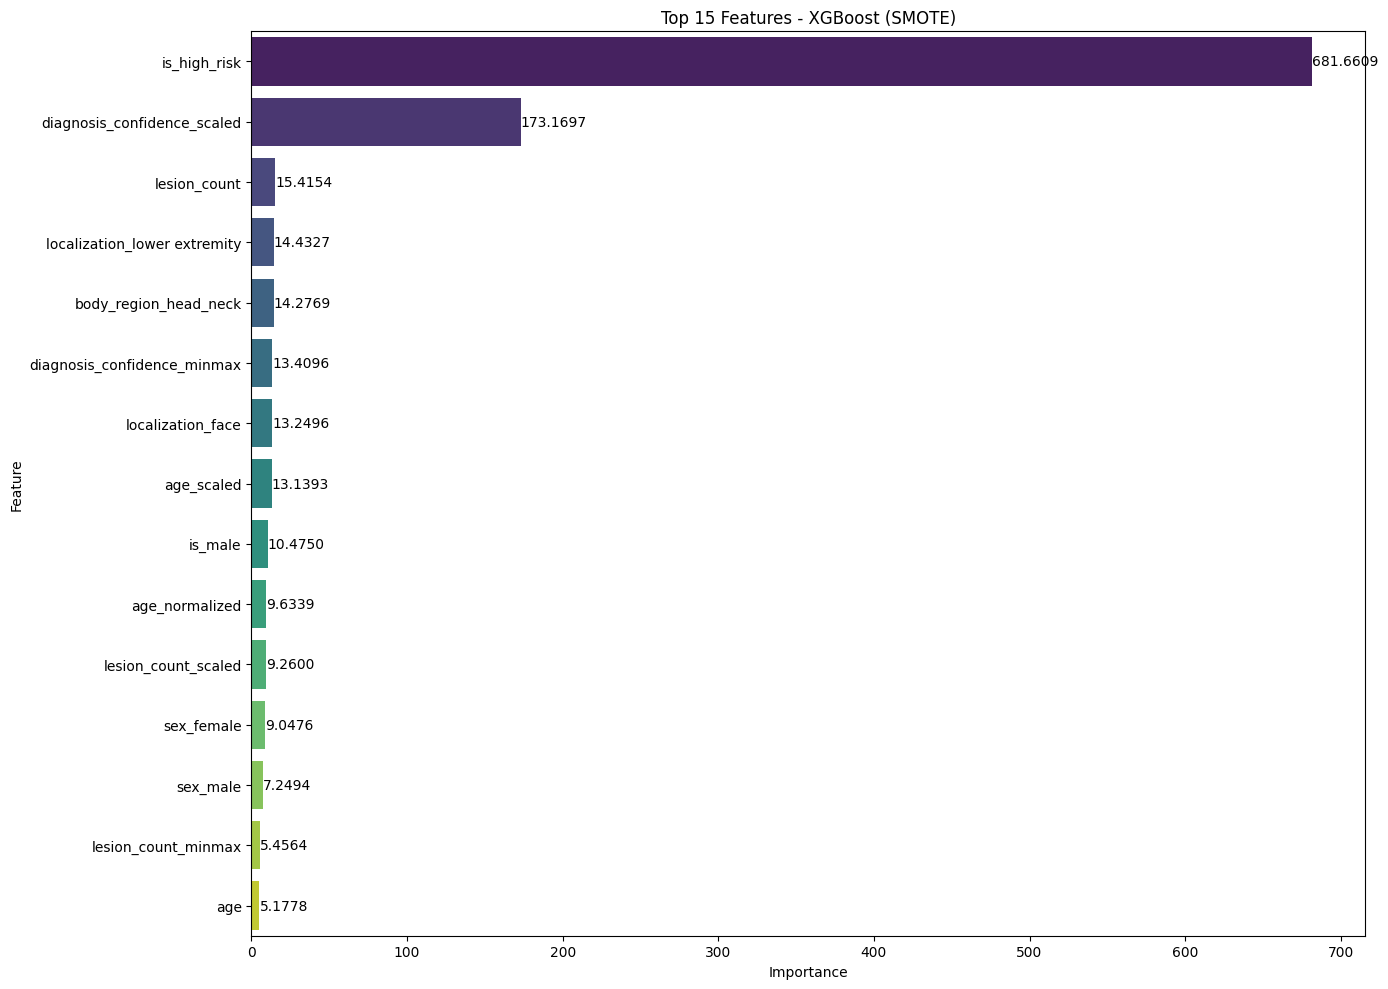


Analyzing model errors on test set...
Number of misclassified samples: 140 out of 2003 (6.99%)
False positives (incorrectly predicted as melanoma): 118
False negatives (melanomas missed): 22


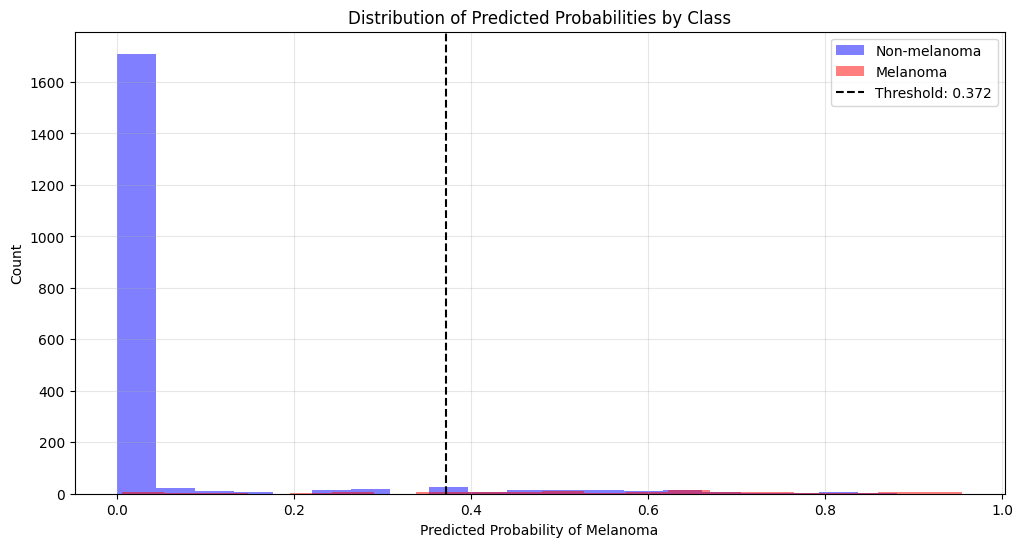


Summary performance report:
Best model: XGBoost (SMOTE)
AUC-ROC: 0.9645
Accuracy: 0.9301
Precision: 0.4070
Recall: 0.7864
F1 Score: 0.5364
Optimal threshold: 0.3719

Analysis completed! All results saved to the '../Results' directory.


In [19]:
# Additional model analysis and evaluation

print("\nPerforming more detailed model analysis...")

# Create a subdirectory for result visualizations if it doesn't exist
os.makedirs('../Results', exist_ok=True)

# 1. Learning curves - understand how model performance improves with more data
from sklearn.model_selection import learning_curve

print("\nGenerating learning curves to understand model performance vs. training size...")

# Define the training sizes to evaluate
train_sizes = np.linspace(0.1, 1.0, 5)

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train_binary,
    train_sizes=train_sizes,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Calculate mean and std for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1 score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, color='green', marker='s', markersize=5, label='Validation F1 score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')
plt.title(f'Learning Curves - {best_model_name}')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.savefig(f'../Results/learning_curve_{best_model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. More detailed feature importance analysis
print("\nDetailed feature importance analysis...")

# Create a more detailed visualization of top features
plt.figure(figsize=(14, 10))
top_n = min(30, len(feature_importance))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Features - {best_model_name}')

# Add importance values to the bars
for i, v in enumerate(feature_importance.head(top_n)['Importance']):
    ax.text(v + 0.001, i, f"{v:.4f}", va='center')

plt.tight_layout()
plt.savefig(f'../Results/detailed_feature_importance_{best_model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Analyze model errors on test set
print("\nAnalyzing model errors on test set...")

# Get test predictions using optimal threshold
test_probas = best_model.predict_proba(X_test)[:, 1]
test_preds = (test_probas >= best_f1_threshold).astype(int)

# Find misclassified samples
misclassified_idx = np.where(test_preds != y_test_binary)[0]
misclassified_count = len(misclassified_idx)

print(f"Number of misclassified samples: {misclassified_count} out of {len(y_test_binary)} ({misclassified_count/len(y_test_binary)*100:.2f}%)")

# Analyze false positives and false negatives
false_positives = np.where((test_preds == 1) & (y_test_binary == 0))[0]
false_negatives = np.where((test_preds == 0) & (y_test_binary == 1))[0]

print(f"False positives (incorrectly predicted as melanoma): {len(false_positives)}")
print(f"False negatives (melanomas missed): {len(false_negatives)}")

# 4. Plot probability distribution
plt.figure(figsize=(12, 6))
plt.hist(test_probas[y_test_binary == 0], bins=20, alpha=0.5, color='blue', label='Non-melanoma')
plt.hist(test_probas[y_test_binary == 1], bins=20, alpha=0.5, color='red', label='Melanoma')
plt.axvline(x=best_f1_threshold, color='black', linestyle='--', label=f'Threshold: {best_f1_threshold:.3f}')
plt.xlabel('Predicted Probability of Melanoma')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'../Results/probability_distribution_{best_model_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Summary report
print("\nSummary performance report:")
print(f"Best model: {best_model_name}")
print(f"AUC-ROC: {best_model_test_results['auc_roc']:.4f}")
print(f"Accuracy: {best_model_opt_results['accuracy']:.4f}")
print(f"Precision: {best_model_opt_results['precision']:.4f}")
print(f"Recall: {best_model_opt_results['recall']:.4f}")
print(f"F1 Score: {best_model_opt_results['f1_score']:.4f}")
print(f"Optimal threshold: {best_f1_threshold:.4f}")

# Save summary results
summary = {
    'model': best_model_name,
    'auc_roc': best_model_test_results['auc_roc'],
    'accuracy': best_model_opt_results['accuracy'],
    'precision': best_model_opt_results['precision'],
    'recall': best_model_opt_results['recall'],
    'f1_score': best_model_opt_results['f1_score'],
    'threshold': best_f1_threshold
}

pd.DataFrame([summary]).to_csv(f'../Results/model_summary.csv', index=False)
print("\nAnalysis completed! All results saved to the '../Results' directory.")